C:\Users\munee\AppData\Local\Temp\ipykernel_19284\865444103.py:67: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_class = np.squeeze(classes).astype(int)
C:\Users\munee\AppData\Local\Temp\ipykernel_19284\865444103.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_steatosis_grade = np.array([float(fat[0]) for fat in fat_percentages])


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step - classification_output_accuracy: 0.6364 - classification_output_loss: 0.6686 - grade_output_loss: 1476.1422 - grade_output_mae: 26.7123 - loss: 1476.8108 - val_classification_output_accuracy: 0.7273 - val_classification_output_loss: 1.4736 - val_grade_output_loss: 1144.3491 - val_grade_output_mae: 25.3842 - val_loss: 1145.8226
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - classification_output_accuracy: 0.6818 - classification_output_loss: 1.7445 - grade_output_loss: 1174.1860 - grade_output_mae: 23.1103 - loss: 1175.9305 - val_classification_output_accuracy: 0.7273 - val_classification_output_loss: 0.9964 - val_grade_output_loss: 883.0131 - val_grade_output_mae: 22.9520 - val_loss: 884.0096
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - classification_output_accuracy: 0.6818 - classification_output_loss: 1.1423 - grade_output_loss: 951.1484 - grade_output_mae: 21.5298 - loss: 952.2908 - val_classification_output_accuracy: 0.7273 -

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 837ms/step - classification_output_accuracy: 0.7273 - classification_output_loss: 0.4200 - grade_output_loss: 575.2131 - grade_output_mae: 21.5339 - loss: 575.6331
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Test AUC for Fatty Liver Detection: 0.958
Mean Absolute Error for Steatosis Grading: 21.534
Patient 1: Fatty Liver
Steatosis Grade for Patient 1: Grade 2 (38.88% fat)
Patient 2: Fatty Liver
Steatosis Grade for Patient 2: Grade 2 (35.99% fat)
Patient 3: Fatty Liver
Steatosis Grade for Patient 3: Grade 2 (38.99% fat)
Patient 4: Fatty Liver
Steatosis Grade for Patient 4: Grade 3 (33.55% fat)
Patient 5: Fatty Liver
Steatosis Grade for Patient 5: Grade 1 (32.41% fat)
Patient 6: Fatty Liver
Steatosis Grade for Patient 6: Grade 2 (45.26% fat)
Patient 7: Fatty Liver
Steatosis Grade for Patient 7: Grade 2 (42.55% fat)
Patient 8: Fatty Liver
Steatosis Grade for Patient 8: Grade 2 (41.95% fat)
Patient 9: Fatty Liver
Steatosis Grade for Patient 9: Grade 2 (39.36% fat)
Patie

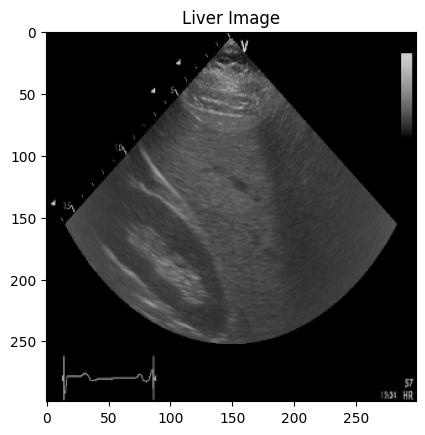

In [ ]:
import numpy as np
import scipy.io
import cv2
import matplotlib.pyplot as plt
import h5py
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.layers import Dense, Flatten, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score

fname='dataset_liver_bmodes_steatosis_assessment_IJCARS.mat'
mat = scipy.io.loadmat(fname)

# ✅ Define the missing CustomScaleLayer
class CustomScaleLayer(Layer):
    def __init__(self, scale=1.0, **kwargs):
        super(CustomScaleLayer, self).__init__(**kwargs)
        self.scale = scale

    def call(self, inputs):
        return inputs * self.scale  # Modify this if needed

    def get_config(self):
        config = super().get_config()
        config.update({"scale": self.scale})
        return config

# ✅ Load the dataset
fname = 'dataset_liver_bmodes_steatosis_assessment_IJCARS.mat'
mat = scipy.io.loadmat(fname)
data_array = mat['data']

# ✅ Extract fields from the structured array
patient_ids = data_array['id'][0]
classes = data_array['class'][0]
fat_percentages = data_array['fat'][0]
image_arrays = data_array['images'][0]

# ✅ Function to assign liver steatosis grade
def assign_steatosis_grade(fat_percentage):
    if fat_percentage < 5:
        return 0
    elif 5 <= fat_percentage <= 33:
        return 1
    elif 34 <= fat_percentage <= 66:
        return 2
    else:
        return 3

y_grade = np.array([assign_steatosis_grade(fat) for fat in fat_percentages])

# ✅ Image preprocessing function
def preprocess_image(img):
    img_resized = cv2.resize(img, (299, 299))
    img_rgb = np.stack([img_resized]*3, axis=-1)
    return img_rgb / 255.0

# ✅ Preprocess images
processed_images = [
    [preprocess_image(img) for img in patient]
    for patient in image_arrays
]

X = np.array([np.mean(patient, axis=0) for patient in processed_images])
y_class = np.squeeze(classes).astype(int)
y_steatosis_grade = np.array([float(fat[0]) for fat in fat_percentages])

# ✅ Split the dataset
X_train, X_test, y_train_class, y_test_class, y_train_grade, y_test_grade = train_test_split(
    X, y_class, y_steatosis_grade, test_size=0.2, random_state=42
)

# ✅ Build the model
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
x = base_model.output
x = Flatten()(x)
x = CustomScaleLayer(scale=0.17)(x)  # ✅ Ensure CustomScaleLayer is included

classification_output = Dense(1, activation='sigmoid', name='classification_output')(x)
grade_output = Dense(1, activation='linear', name='grade_output')(x)

model = Model(inputs=base_model.input, outputs=[classification_output, grade_output])

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(),
              loss={'classification_output': 'binary_crossentropy', 'grade_output': 'mean_squared_error'},
              metrics={'classification_output': 'accuracy', 'grade_output': 'mae'})

# ✅ Train the model
history = model.fit(X_train, {'classification_output': y_train_class, 'grade_output': y_train_grade},
                    epochs=10, batch_size=256, validation_data=(X_test, {'classification_output': y_test_class, 'grade_output': y_test_grade}))

# ✅ Save the model with custom objects
model.save("model.keras")

# ✅ Evaluate the model
test_loss, test_classification_loss, test_grade_loss, test_classification_acc, test_grade_mae = model.evaluate(
    X_test, {'classification_output': y_test_class, 'grade_output': y_test_grade}
)

# ✅ Predict on test data
y_pred_class, y_pred_grade = model.predict(X_test)

# ✅ Evaluate classification performance
test_auc = roc_auc_score(y_test_class, y_pred_class)
print(f'Test AUC for Fatty Liver Detection: {test_auc:.3f}')
print(f'Mean Absolute Error for Steatosis Grading: {test_grade_mae:.3f}')

# ✅ Print Predictions
for i in range(len(y_pred_class)):
    classification = y_pred_class[i][0]
    grade = y_pred_grade[i][0]

    if classification > 0.5:
        print(f"Patient {i+1}: Fatty Liver")
        if grade < 5:
            steatosis_grade = 0
        elif 5 <= grade <= 33:
            steatosis_grade = 1
        elif 34 <= grade <= 66:
            steatosis_grade = 2
        else:
            steatosis_grade = 3

        print(f"Steatosis Grade for Patient {i+1}: Grade {steatosis_grade} ({grade:.2f}% fat)")
    else:
        print(f"Patient {i+1}: Healthy Liver")

# ✅ Display an example image
plt.imshow(X_test[6])
plt.title('Liver Image')
plt.show()
